In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Debug
# %matplotlib notebook
# pd.options.display.max_rows = 200

In [66]:
# Used to get nearest neighbors for surface normals
depthXY_to_cloudXYZ = {}

# Converts lidar point cloud csv to depth matrix

df = pd.read_csv("depth-map-data/5-car/1503619158691071272-cloudpoint.csv", 
                 names = ['x', 'y', 'z', 'intensity', 'ring', 'rotation', 'revolution'])

df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
# np.arctan2 is element-wise arc tangent that chooses the quadrant correctly
df['rotation-angle'] = np.arctan2(df['x'], df['y']) + np.pi
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])

# img_height is number of lasers
# img_width is number of pts/number of lasers
img_height = 80
img_width = 2088

# calculate histogram for inclination angle
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])
df_inclination_arr = df['inclination-angle'].as_matrix()
hist, bin_edges = np.histogram(df_inclination_arr, bins = img_height - 1)

df.sort_values(['rotation-angle'], inplace = True)

bin_size = 64

depth_img = np.zeros((img_width, img_height))

for i in range(img_width):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice[['x', 'y', 'z', 'distance']]
    pixel_bin_arr = np.digitize(df_rot_slice['inclination-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_vert_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_vert_loc] = df_rot_slice_arr['distance'].iloc[j]
        cloudXYZ = (df_rot_slice_arr['x'].iloc[j], df_rot_slice_arr['y'].iloc[j], 
                    df_rot_slice_arr['z'].iloc[j])
        depthXY_to_cloudXYZ[(i, pixel_vert_loc)] = cloudXYZ

In [67]:
# Converts depth matrix to surface normal matrix
minNorm = 0
# image dimensions in NumPy array,
# 3rd dimension is for each component of normal vector
normal_img = np.zeros((img_width, img_height, 3))
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius_close = 2
nn_radius_far = 2
# the following var are automatically set in algorithm
nn_radius = 0
nn_radius_for_loop = max(nn_radius_close, nn_radius_far)


for x in range(nn_radius_for_loop, depth_img.shape[0] - nn_radius_for_loop):
    for y in range(nn_radius_for_loop, depth_img.shape[1] - nn_radius_for_loop):
        if not depth_img[x][y]:
            continue
            
        # logic used for diff nn radius for close and far
        if depth_img[x][y] <= 20:
            nn_radius = nn_radius_close
        else:
            nn_radius = nn_radius_far
        
        # used to check for depth discontinuities
        curr_depth = depth_img[x][y]
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                x_coord = x_start + x_n
                y_coord = y_start + y_n
                                
                # if there is no depth discontinuity, add it
                if np.abs(depth_img[x_coord][y_coord] - curr_depth) < .5:
                    if (x_coord, y_coord) in depthXY_to_cloudXYZ:
                        cloudXYZ_value = depthXY_to_cloudXYZ[(x_coord, y_coord)]
                        nn_arr.append(cloudXYZ_value)
        
        # can only do PCA if more than one nearest neighbor
        if (len(nn_arr) <= 1):
            continue
        nn_matrix = np.array(nn_arr)
               
        # mean center the data
        nn_matrix -= np.mean(nn_matrix, axis=0)
        # calculate the covariance matrix
        cov_matrix = np.cov(nn_matrix, rowvar=False)
        # calculate eigenvectors & eigenvalues of the covariance matrix
        # use 'eigh' rather than 'eig' since R is symmetric, 
        # the performance gain is substantial
        # eigenvectors are in increasing order of eigenvalue
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        # sort eigenvectors in decreasing order
        # eigvecs = np.flip(eigvecs, axis=1)
        
        # the eigenvector corresponding to the smallest eigenvalue
        # represents the surface normal of the regression plane
        normal = eigvecs[:,0]
        
        # if surface normal is in the wrong direction, flip it!
        if np.dot(normal, np.array([0, 0, 1]) - 
                  np.array(list(depthXY_to_cloudXYZ[(x, y)]))) <= 0:
            normal = -normal
            
        
        normal_img[x][y][0] = normal[0] * .5 + .5
        normal_img[x][y][1] = normal[1] * .5 + .5
        normal_img[x][y][2] = normal[2] * .25 + .75

In [68]:
# Interpolation

mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, normal_img.shape[0] - nn_radius):
    for y in range(nn_radius, normal_img.shape[1] - nn_radius):
        # skip if not an empty pixel
        if normal_img[x][y][0] or normal_img[x][y][1] or normal_img[x][y][2]:
            continue

        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius

        # find out nearest neighbors' surface normal vectors
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = normal_img[x_start + x_n][y_start + y_n]
                if pixel[0] or pixel[1] or pixel[2]:
                    nn_arr.append(pixel)

        if (len(nn_arr) <= 2):
            continue
        
        nn_matrix = np.array(nn_arr)

        # fill empty pixel with average of filled in neighbors
        nn_avg = np.mean(nn_matrix, axis=0)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping: 
    normal_img[x][y][0] = mapping[(x, y)][0]
    normal_img[x][y][1] = mapping[(x, y)][1]
    normal_img[x][y][2] = mapping[(x, y)][2]

In [69]:
normal_points = []
normal_colors = []

for x in range(0, normal_img.shape[0]):
    for y in range(0, normal_img.shape[1]):
        depthXY_key = (x, y)
        if depthXY_key in depthXY_to_cloudXYZ:
            normal_points.append(depthXY_to_cloudXYZ[(x, y)])
            normal_colors.append(normal_img[x][y])

normal_points = np.array(normal_points)
np.savetxt("normal_points.csv", normal_points, delimiter=",")

normal_colors = np.array(normal_colors)
np.savetxt("normal_colors.csv", normal_colors, delimiter=",")

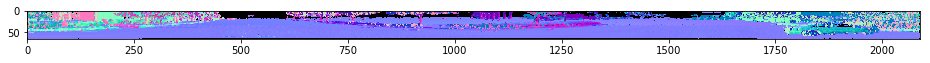

In [70]:
# For saving to 2D image only

normal_img = np.rot90(normal_img)        
# Cut off top of image
cut_off = 14
normal_img = normal_img[cut_off:][:]

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(normal_img)

fig.savefig('surface-normal.png', dpi = 300)

In [12]:
normal_ply_file_name = "normals.ply"

with open(normal_ply_file_name, 'w') as f:
    f.write("ply\n")
    f.write("format ascii 1.0\n")
    f.write("element vertex {}\n".format(len(normal_points)))
    f.write("property float32 x\n")
    f.write("property float32 y\n")
    f.write("property float32 z\n")
    f.write("property float32 nx\n")
    f.write("property float32 ny\n")
    f.write("property float32 nz\n")
    f.write("end_header\n")
    for i in range(len(normal_points)):
        normal = normal_colors[i]
        f.write("{} {} {} {} {} {}\n".format(normal_points[i][0], normal_points[i][1], normal_points[i][2],
                                             normal[0], normal[1], normal[2]))